# E-Commerce Website Analyze A/B Test
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusion)
<a id='intro'></a>
## Introduction

For this project, i will be working to understand the results of an A/B test run by an e-  commerce website. my goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('(group == "treatment" & landing_page != "new_page") | (group == "control" & landing_page == "new_page") ').shape[0]

3893

Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query('(group == "treatment" & landing_page == "new_page") | (group == "control" & landing_page == "old_page")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id.value_counts().index[0]

773192

Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop_duplicates(subset='user_id')
# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().any()

False

What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2.query('group == "control"')['converted'].mean()
p_control

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2.query('group == "treatment"')['converted'].mean()
p_treatment

0.11880806551510564

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [18]:
df2.landing_page.value_counts()[0] / df2.landing_page.shape[0]

0.50006194422266881

>**Observation**
* probability of an individual converting regardless of the page they receive : 0.11959708724499628
* probability that an individual received the new page : 0.5000619442226688
* control(old page)(0.1203863045004612) has probability they converted a little more than treatment (new page) (0.11880806551510564)
* we can't say that new page leads to more conversions, the probability of new page is roughly 50% .

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>* Null hypothese is $H_0: p_{old} >= p_{new}$
* Alternative hypothese is $H_1: p_{old} < p_{new}$

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.group.value_counts()[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.group.value_counts()[1]
n_old

145274

**e.** Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [23]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, p=[p_new,1-p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 0])

**f.** **Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], n_old, p=[p_old,1-p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

**g.** the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00024983774167974815

**h.** **Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# Sampling distribution 
"""
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=[p_new,1-p_new])
    old_page_converted= np.random.choice([0,1], n_old, p=[p_old,1-p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
"""
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation


**i.** **Histogram**<br> 

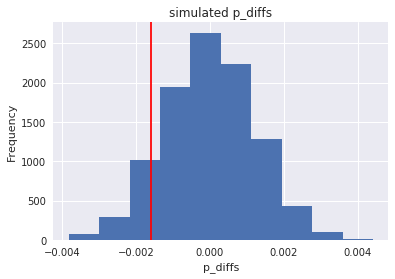

In [27]:
plt.hist(p_diffs)
# mark the actual difference observed in the df2 data (recall obs_diff)
plt.axvline(obs_diff,c='r')
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('simulated p_diffs');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

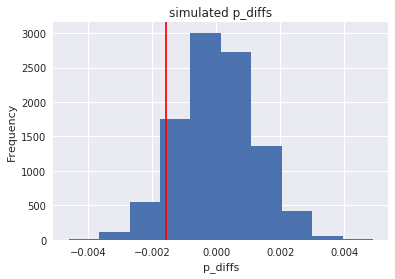

In [28]:
null_values = np.random.normal(0, np.std(p_diffs), size=len(p_diffs))
plt.hist(null_values)
plt.axvline(obs_diff,c='r')
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('simulated p_diffs');

In [29]:
#calculate the proportion of p_diffs greater than the observe difference
(null_values > obs_diff).mean()

0.91000000000000003

**k.** explain part j above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 

>* The value is called P-Value.
* there is a difference between the new and old pages P-Value > Type I error rate (0.05) So we fail to reject the null hypothesis, so that the control page has higher probability of convert rate than treatment page.

**l.** **Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('converted == 1 and landing_page == "old_page"').user_id.nunique()
print(convert_old)

# number of conversions with the new_page
convert_new = df2.query('converted == 1 and landing_page == "new_page"').user_id.nunique()
print(convert_new)

# number of individuals who were shown the old_page
n_old = df2.landing_page.value_counts()[1]
print(n_old)

# number of individuals who received new_page
n_new = df2.landing_page.value_counts()[0]
print(n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489
17264
145274
145310


**m.**  use `sm.stats.proportions_ztest()` to compute test statistic and p-value.

In [31]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>* the z-score of 1.31092419842 < 1.645 , we fail to reject the null hypothesis
* in j and k it suggests there is no significant difference between old page and new page conversions

<a id='regression'></a>
### Part III - A regression approach
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should be performing in this case?

>* Logistic regression: is predicts categorical responses when there are only two possible outcomes.
* We have 2 posible outcomes (converted, not converted) ,so the type of of regression should we be performing in this case is Logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [32]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group']).treatment
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to instantiate your regression model on the two columns we created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [33]:
log_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = log_model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of the model below, and use it as necessary to answer the following questions.

In [34]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-01-25 16:51 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>* the p-value associated with ab_page is 0.1899, P-Value < Type I error rate (0.05) this mean
* differ from the value you found in Part II
  * p-value in Part II the null and alternative hypotheses :
    * Null hypothese is $H_{0}: p_{old} >= p_{new}$
    * Alternative hypothese is $H_{1}: p_{old} < p_{new}$
    * In $H_{1}$ The conversion rate of the old_page is less than the conversion rate of the new_page. This assumes a one-tailed test.
  * p-value in Part III the null and alternative regression model :
    * Null hypothese is $H_{0}: p_{old} - p_{new} =0 $
    * Alternative hypothese is $H_{1}: p_{old} - p_{new} !=0$
    * In $H_{1}$ the conversion rate of the old_page is different to the conversion rate of the new_page. This assumes a two-tailed test.


Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>* It is a good idea to consider other factors in order to identify other potential influences on the conversion rate.
* Disadvantages to adding additional terms into your regression model:
    * the model gets more complex
    * using incomplete data
    * falsely concluding that a correlation is a causation.
    * multicollinearity

**Adding countries**

In [35]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
# Join with the df2 dataframe
df_merged = df2.merge(countries_df,on='user_id',how='left')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [37]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])
df_merged.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


**Fit the model and obtain the results**


In [38]:
# Fit the model, and summarize the results
df_merged['intercept'] = 1
log_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
result = log_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-01-25 16:51 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

>**Observation**
* the ab_page p-value associated is 0.1912 , P-Value > Type I error rate (0.05)
* the UK p-value associated is 0.0745 , P-Value > Type I error rate (0.05)
* the Us p-value associated is 0.1295 , P-Value > Type I error rate (0.05)
* For each unit for new_page decrease convert will be 1.5% more likely to happen, when all other varible constant
* For each unit for UK decrease convert will be 5% more likely to happen, when all other varible constant
* For each unit for US decrease convert will be 4% more likely to happen, when all other varible constant

**Interaction between page and country to see if there significant effects on conversion.**

In [39]:
#Interaction between page and country 
df_merged['UK_ab_page'] = df_merged.UK * df_merged.ab_page
df_merged['CA_ab_page'] = df_merged.CA * df_merged.ab_page 


In [40]:
# Fit the model, and summarize the results
log_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])
results = log_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-01-25 16:51 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

>**Observation**
* Look at all of p-values in the summary, and compare against the Type I error rate (0.05).
    * the ab_page p-value associated is 0.1323 , P-Value > Type I error rate (0.05)
    * the UK p-value associated is 0.7598 , P-Value > Type I error rate (0.05)
    * the CA p-value associated is 0.6418 , P-Value > Type I error rate (0.05)
    * the UK_ab_page p-value associated is 0.2377 , P-Value > Type I error rate (0.05)
    * the CA_ab_page p-value associated is 0.3833 , P-Value > Type I error rate (0.05)
* Can you reject/fail to reject the null hypotheses (regression model)?
    * yes we fail to reject the null hypotheses
* Comment on the effect of page and country to predict the conversion.
    * The country do not appear to impact conversions.

<a id='conclusion'></a>
## Conclusions
>  * After tests the three different tests, we came to the same result in all three, which is to keep the old page and not change it with the new page. As there is insufficient evidence to say that the new page conversion rate is higher than the old page conversion rate, and there is also no evidence that countries are affected by the conversion rate.
>* It is best to focus on the development of another new page or improve the old one.